In [1]:
import numpy as np
%matplotlib inline
from datavyz.main import graph_env

In [96]:
ge = graph_env('visual_stim')

In [210]:
# parameters of the model

model = {
    # units of the visual field is degree
    'screen_width':16./9.*30, # degree
    'screen_height':30.,
    'screen_dpd':5, # dot per degree (dpd)
    # receptive fields
    'rf_seed':1,
    'rf_size':2,
    'width_factor':2.,
    # temporal filtering
    'tau_adapt':500e-3,
    'tau_delay':30e-3,
    'fraction_adapt':0.2,
    # non-linear amplification
    'NL_threshold':0.1,
    'NL_slope_Hz_per_Null':10.,
    # # virtual eye movement
    'duration_distance_slope':1.9e-3, # degree/s
    'duration_distance_shift':63e-3, # s
    # numerical simulations
    'dt':10e-3,
    'tstop':1.,
}

# Visual setting

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0ede4790>)

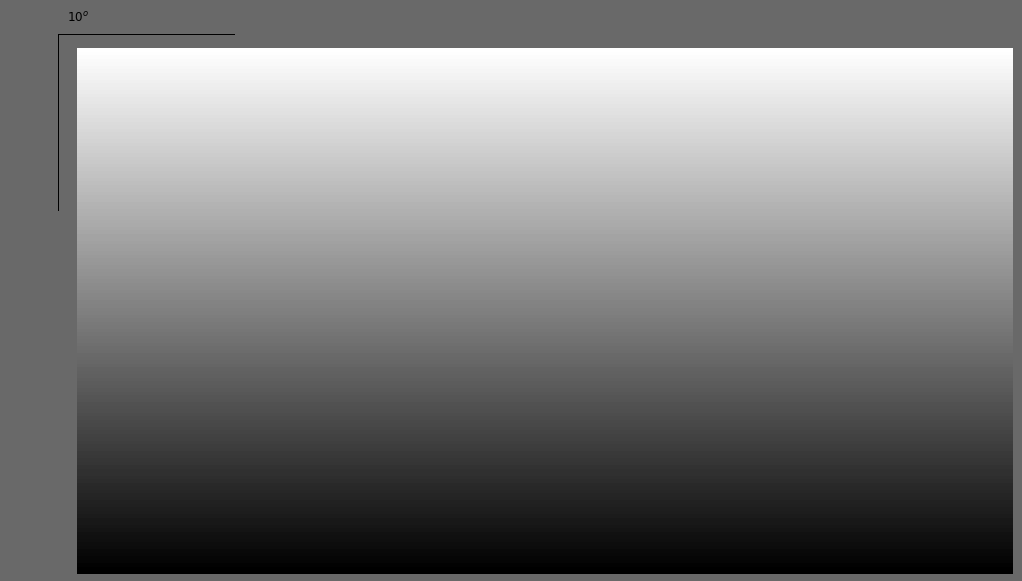

In [4]:




SCREEN = {'width':16./9.*30, # degree
          'height':30.,
          'dpd':5} # dot per degree
SCREEN['Xd_max'] = int(model['screen_width']*model['screen_dpd'])
SCREEN['Yd_max'] = int(model['screen_height']*model['screen_dpd'])
SCREEN['xd_1d'], SCREEN['yd_1d'] = np.arange(SCREEN['Xd_max']), np.arange(SCREEN['Yd_max'])
SCREEN['xd_2d'], SCREEN['yd_2d'] = np.meshgrid(SCREEN['xd_1d'], SCREEN['yd_1d'], indexing='ij')
SCREEN['x_1d'], SCREEN['y_1d'] = SCREEN['xd_1d']/SCREEN['dpd'], SCREEN['yd_1d']/SCREEN['dpd']
SCREEN['x_2d'], SCREEN['y_2d'] = np.meshgrid(SCREEN['x_1d'], SCREEN['y_1d'], indexing='ij')

def plot(Z,
         ax=None,
         Ybar_label='',
         Xbar_label='10$^o$'):
    if ax is None:
        fig, ax = ge.figure()
    else:
        fig = None
    ge.twoD_plot(SCREEN['x_2d'].flatten(),
                 SCREEN['y_2d'].flatten(),
                 1.-Z.flatten(),
                 vmin=0, vmax=1,
                 colormap=ge.binary,
                 ax=ax)
    ge.draw_bar_scales(ax, Xbar=10., Ybar_label=Ybar_label,
                       Ybar=10., Xbar_label=Xbar_label,
                       xyLoc=(-0.02*model['screen_width'], 1.02*model['screen_height']),
                       loc='left-top')
    ax.axis('equal')
    ax.axis('off')
    return fig, ax

plot(SCREEN['y_2d']/SCREEN['y_2d'].max())

# Cells with gabor receptive fields

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0e8291d0>)

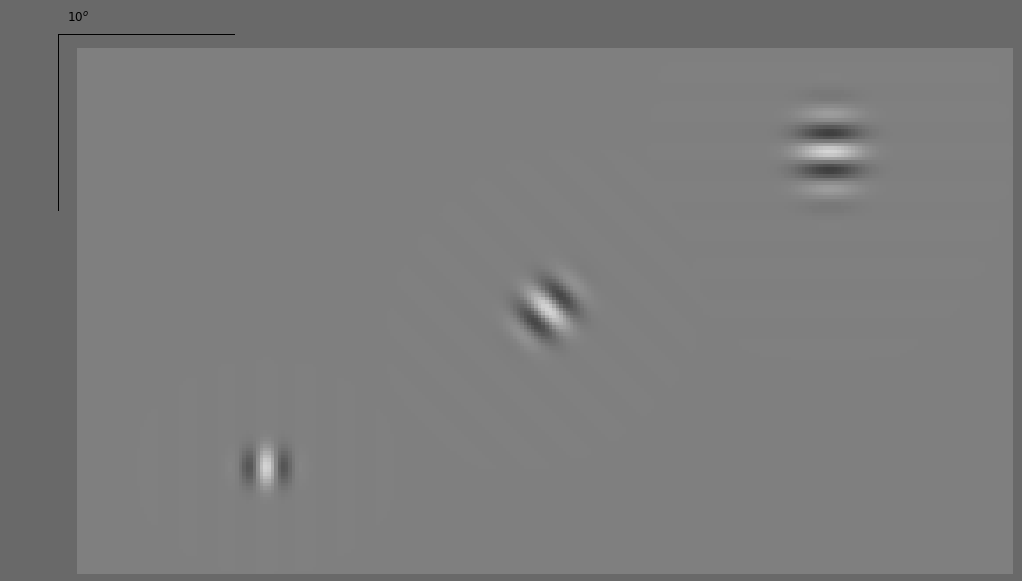

In [79]:
from gabor_filters import gabor


N=3 # picking 10 cells

RANGES = {'x0':[0.2*SCREEN['width'], 0.8*SCREEN['width']],
          'y0':[0.2*SCREEN['height'], 0.8*SCREEN['height']],
          'freq':[1./(0.05*SCREEN['height']), 1./(0.1*SCREEN['height'])],
          'size':[0.02*SCREEN['height'], 0.1*SCREEN['height']],
          'beta':[1., 2.],
          'theta':[0., np.pi/2.],
          'psi':[0., np.pi]}
RANGES = {'x0':[0.2*SCREEN['width'], 0.8*SCREEN['width']],
          'y0':[0.2*SCREEN['height'], 0.8*SCREEN['height']],
          'freq':np.ones(2)/(0.075*SCREEN['height']),
          'size':[0.03*SCREEN['height'], 0.05*SCREEN['height']],
          'beta':[1.5, 1.5],
          'theta':[0, np.pi/2.],
          'psi':[0., 0]}

CELLS = {}
for icell, key in enumerate(RANGES):
    # CELLS[key] = np.random.uniform(RANGES[key][0], RANGES[key][1], size=N)
    CELLS[key] = np.linspace(RANGES[key][0], RANGES[key][1], N)

Z = 0*SCREEN['x_2d']

def cell_gabor(i, CELLS, SCREEN,
               x_shift=0.,
               y_shift=0.,
               normalized=False,
               width_factor=2., # to determine the center condition
               with_center_conditions=False):
    
    gb = gabor(SCREEN['x_2d'], SCREEN['y_2d'],
               x0=CELLS['x0'][i]+x_shift,
               y0=CELLS['y0'][i]+y_shift,
               freq=CELLS['freq'][i],
               size=CELLS['size'][i],
               beta=CELLS['beta'][i],
               theta=CELLS['theta'][i],
               psi=CELLS['psi'][i])

    if with_center_conditions:
        
        # find x-y boundaries, including the possible shift in visual space
        cond_x = (SCREEN['x_1d']>=CELLS['x0'][i]+x_shift-width_factor*CELLS['size'][i]) &\
            (SCREEN['x_1d']<CELLS['x0'][i]+x_shift+width_factor*CELLS['size'][i])
        cond_y = (SCREEN['y_1d']>=CELLS['y0'][i]+y_shift-width_factor*CELLS['size'][i]) &\
            (SCREEN['y_1d']<CELLS['y0'][i]+y_shift+width_factor*CELLS['size'][i])

        if normalized:
            # norm_factor = convolution_function(gb[cond_x, cond_y], gb[cond_x, cond_y])
            norm_factor = convolution_function(gb, gb)
        else:
            norm_factor = 1.
        
        
        return gb/norm_factor, cond_x, cond_y

    else:
        if normalized:
            norm_factor = convolution_function(gb, gb)
        else:
            norm_factor = 1.
    
        return gb/norm_factor
    
    
for i in range(N):
    z = cell_gabor(i, CELLS, SCREEN)+0.5
    Z += z/N

plot(Z)    


# Stimuli: 1) Drifting gratings

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0e7cb650>)

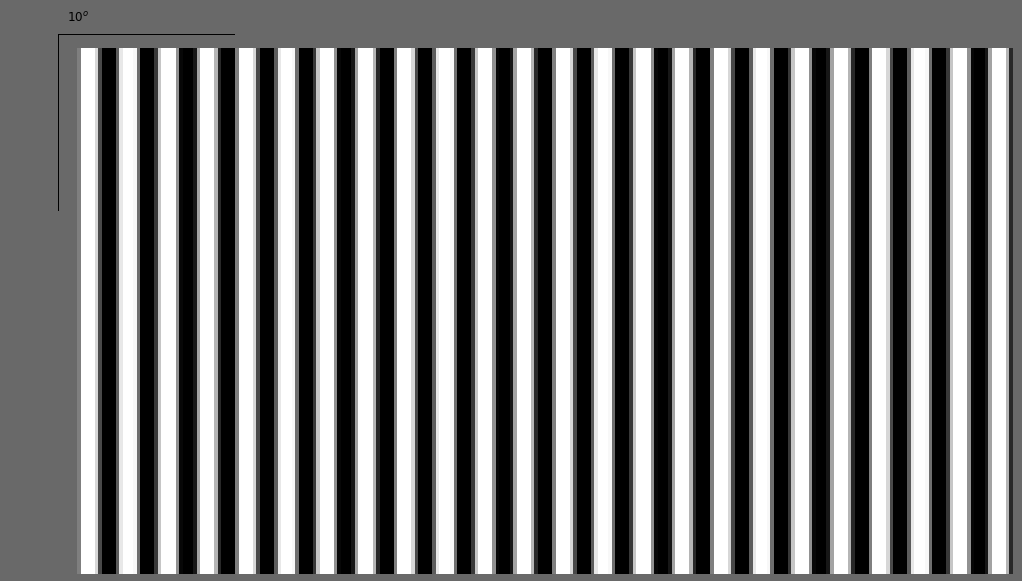

In [59]:
spatial_freq, theta = CELLS['freq'][0], CELLS['theta'][0]

# Centering and Rotation
x_theta = SCREEN['x_2d'] * np.cos(theta) + SCREEN['y_2d'] * np.sin(theta)
y_theta = -SCREEN['x_2d'] * np.sin(theta) + SCREEN['y_2d'] * np.cos(theta)


Z = np.sin(2*np.pi*spatial_freq*x_theta)+.5

plot(Z)


# Linear filtering

In [80]:
import itertools

# build_iterator
def convolution_function(array1, array2):
    tot = 0
    for i, j in itertools.product(range(array1.shape[0]), range(array1.shape[1])):
        tot += array1[i,j]*array2[i,j]
    return tot

def convol_func_gabor_restricted(array, icell, CELLS, SCREEN,
                                 x_shift=0,
                                 y_shift=0,
                                 width_factor=2.):

    # compute gabor filter of cell icell, with the gaze-shift
    gb, cond_x, cond_y = cell_gabor(icell, CELLS, SCREEN,
                                    x_shift=x_shift, y_shift=y_shift,
                                    normalized=True,
                                    with_center_conditions=True)

    iterator = itertools.product(SCREEN['xd_1d'][cond_x], SCREEN['yd_1d'][cond_y])
    
    if array.shape==gb.shape:
        tot = 0
        for i, j in iterator:
            tot += gb[i,j]*array[i,j]
    elif array[0, :, :].shape==gb.shape:
        tot = np.zeros(array.shape[0])
        for it in len(tot):
            for i, j in iterator:
                tot[it] += gb[i,j]*array[it, i, j]
    else:
        print('uable to match array shape')
        tot=None

    return tot

In [81]:
CELLS = {'x0':[30,30],
         'y0':[15,25],
         'freq':np.ones(2)/(0.075*SCREEN['height']),
         'size':[1, 1],
         'beta':[1.5, 1.5],
         'theta':[0, 0],
         'psi':[0., 0]}
# checking the convolution function
gb1, gb2 = cell_gabor(0, CELLS, SCREEN), cell_gabor(1, CELLS, SCREEN)
print(convol_func_gabor_restricted(gb1, 0, CELLS, SCREEN))
print(convolution_function(gb1, gb1))
# Let's present gb2 on the screen, and check that a shifted gb1 matches
#plot(gb1+.5)
#plot(gb2+.5) 
print(convol_func_gabor_restricted(gb2, 0, CELLS, SCREEN))
print(convol_func_gabor_restricted(gb2, 0, CELLS, SCREEN, y_shift=10))

0.9921004561066805
32.07690698301965
1.753258988288381e-24
0.9921004561066804


(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7a0c068c90>)

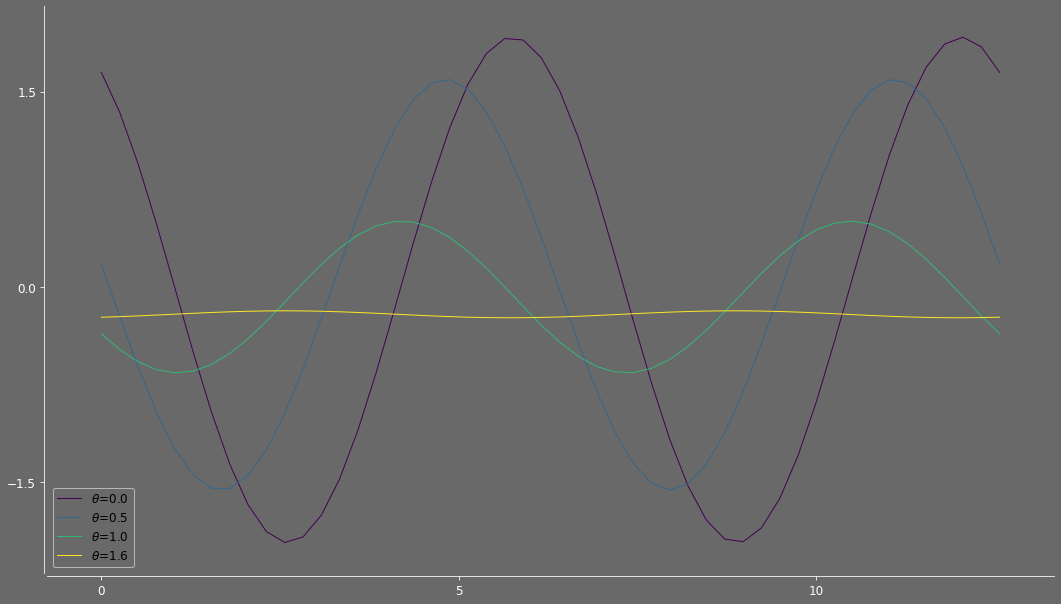

In [87]:
N=4
CELLS = {'x0':30*np.ones(N),
         'y0':30*np.ones(N),
         'freq':np.ones(N)/(0.075*SCREEN['height']),
         'size':np.ones(N),
         'beta':1.5*np.ones(N),
         'theta':np.linspace(0, np.pi/2., N),
         'psi':np.zeros(N)}

t = np.linspace(0, 1, 50)# in seconds
PHASES = 4*np.pi*t
LF = [[] for i in range(N)]

spatial_freq, theta = CELLS['freq'][0], CELLS['theta'][0]

# Centering and Rotation
x_theta = SCREEN['x_2d'] * np.cos(theta) + SCREEN['y_2d'] * np.sin(theta)

for phase in PHASES:
    Z = np.sin(2*np.pi*spatial_freq*x_theta+phase)+.5
    for i in range(N):
        LF[i].append(convol_func_gabor_restricted(Z, i, CELLS, SCREEN))
    
ge.plot(PHASES, Y=LF, LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={})

# Temporal filtering

(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79fe7fd2d0>)

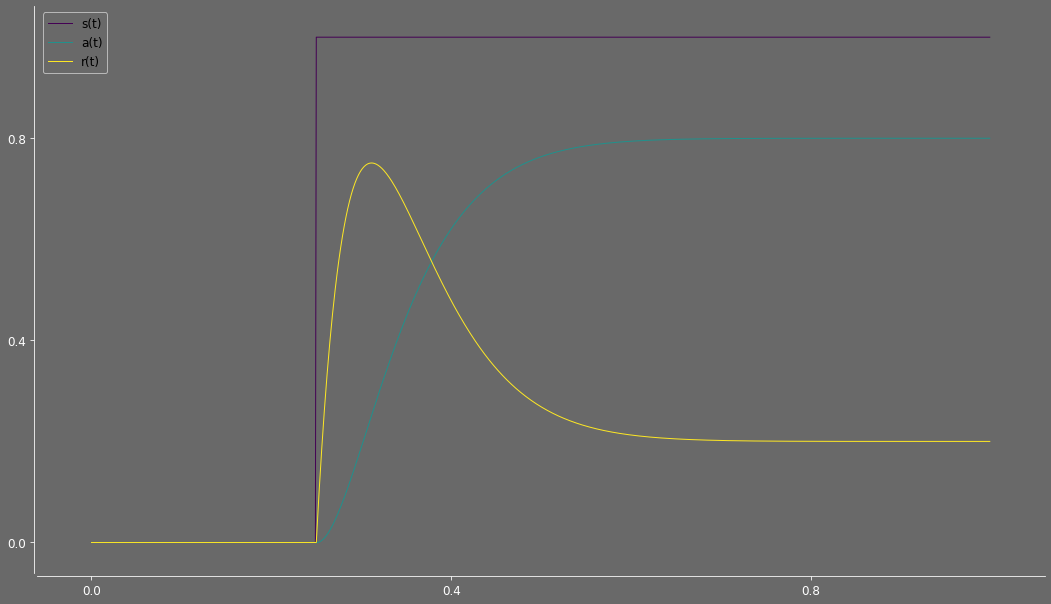

In [123]:

t = np.arange(int(model['tstop']/model['dt']))*model['dt']

s = [1 if tt>t[-1]/4. else 0 for tt in t]

r = np.zeros(len(t))
a = np.zeros(len(t))

def operator_delay_adapt(s, a, r, model):
    """
    r[i+1= r[i]+dt/tau_delay*(-r[i]+s[i]-a[i])
    
    a[i]+dt/tau_adapt*((1-fraction_adapt)/fraction_adapt*r[i]-a[i])
    """
    return [r+model['dt']/model['tau_delay']*(s-r-a),
            a+model['dt']/model['tau_adapt']*((1-model['fraction_adapt'])/model['fraction_adapt']*r-a)]


for i in range(len(t)-1):
    r[i+1], a[i+1] = operator_delay_adapt(s[i], a[i], r[i], model)

ge.plot(t, Y=[s,a,r], LABELS=['s(t)','a(t)','r(t)'], legend_args={})


(<Figure size 1013.54x572.598 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f79fe77cb90>)

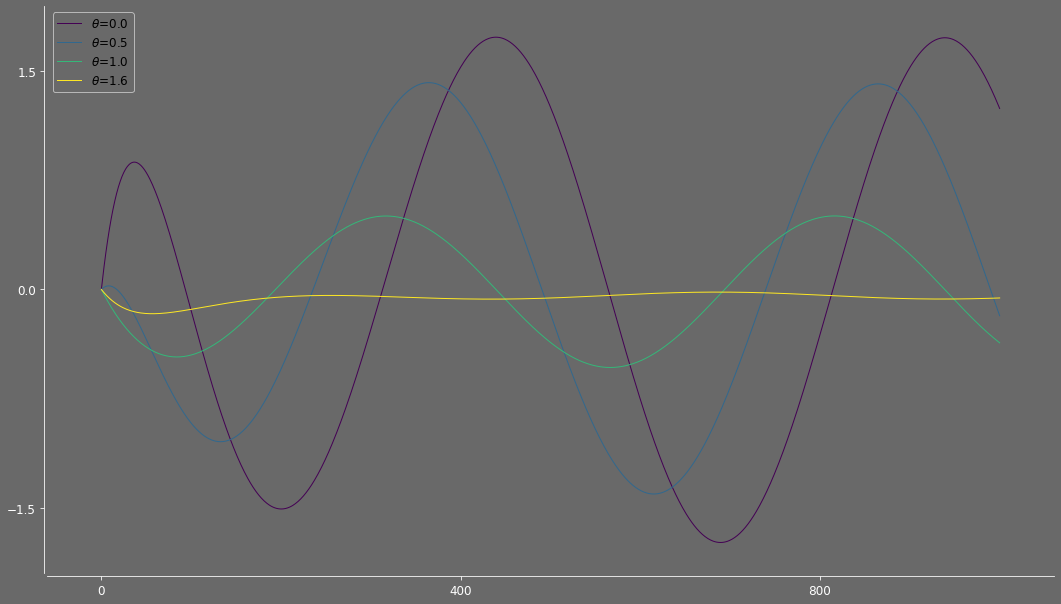

In [126]:
t = np.linspace(0, 1, int(tstop/dt))# in seconds
PHASES = 4*np.pi*t

R, A = [[0] for i in range(N)], [[0] for i in range(N)]

for phase in PHASES:
    Z = np.sin(2*np.pi*spatial_freq*x_theta+phase)+.5
    for i in range(N):
        s = convol_func_gabor_restricted(Z, i, CELLS, SCREEN)
        r, a = operator_delay_adapt(s, A[i][-1], R[i][-1], model)
        A[i].append(a)
        R[i].append(r)
    
ge.plot(Y=R, LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={})

# Non linearity

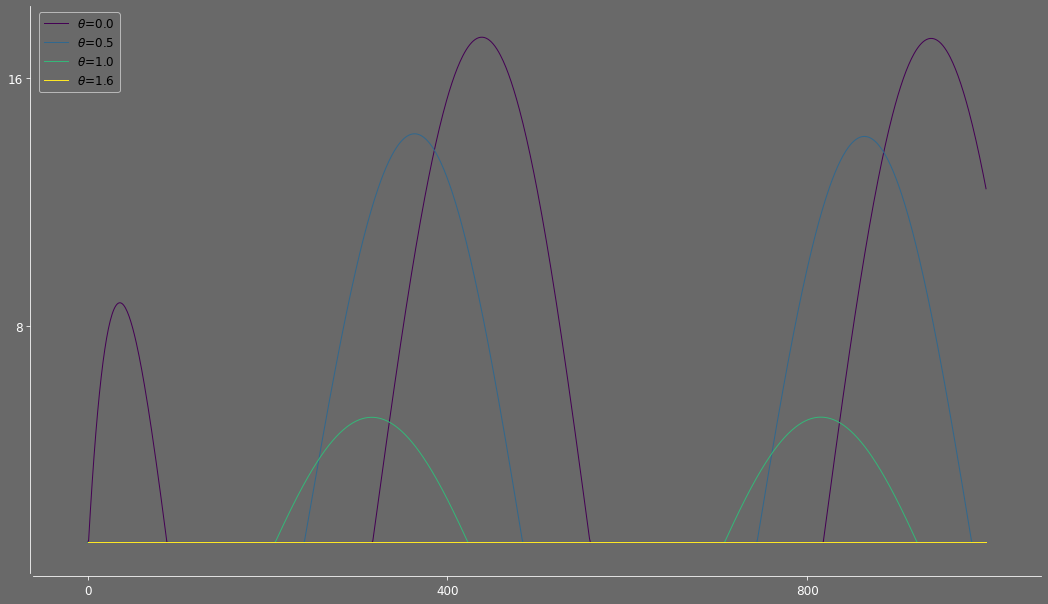

In [166]:

def NL_function(x, model):
    x[x<=model['NL_threshold']] = model['NL_threshold']
    return model['NL_slope_Hz_per_Null']*x

model['NL_threshold'] = 0.1
model['NL_slope_Hz_per_Null'] = 10.

FR = [NL_function(np.array(R[i])[1:], model) for i in range(N)]
_, ax = ge.plot(Y=FR, LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={})
#ge.set_plot(ax, yscale='log')


# Poisson process

In [161]:
RDM = np.random.uniform(0,1,size=(N, len(t)))
SPIKES = [[] for i in range(N)]

for (n, it) in np.argwhere(RDM<np.array(FR)*dt):
    SPIKES[n].append(t[it])

(None, <matplotlib.axes._subplots.AxesSubplot at 0x7f79fdad2290>)

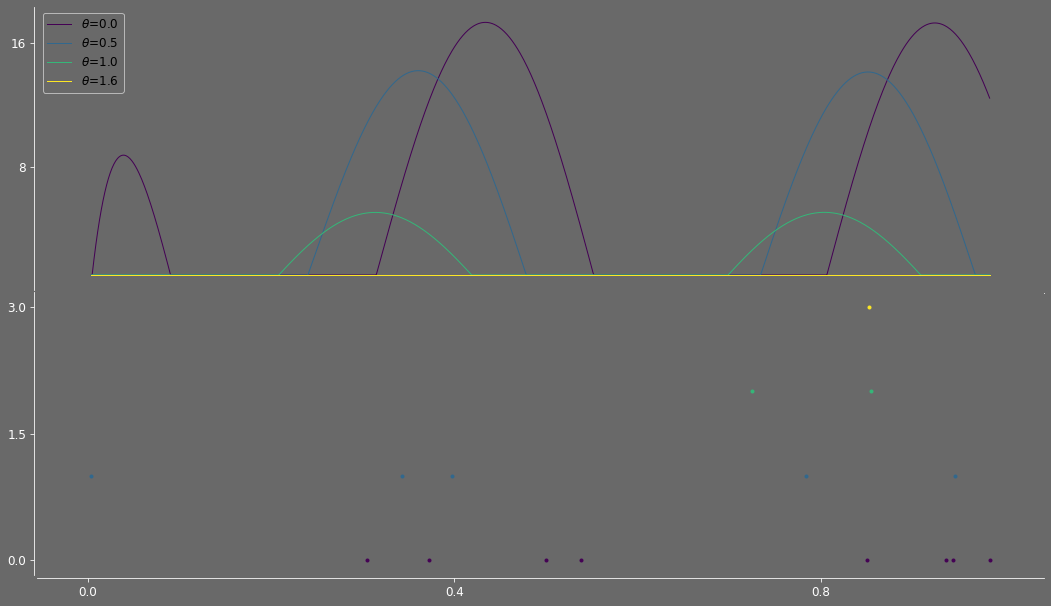

In [175]:
fig, AX = ge.figure(axes=(2,1), figsize=(1.,.5))
ge.plot(t, Y=FR,
        LABELS=['$\\theta$=%.1f'%t for t in CELLS['theta']], legend_args={}, ax=AX[0])
ge.scatter(X=[SPIKES[i] for i in range(N)],
           Y=[i*np.ones(len(SPIKES[i])) for i in range(N)], ax=AX[1])


# Saccadic eye movement

In [ ]:
def duration(distance,
             model):
    """
    from Baudot et al. (2013)

    The saccade amplitudes and intersaccadic intervals were chosen
    randomly from the distribution established for saccadic and head
    gaze movements in the freely behaving cat (Collewijn, 1977). An
    estimate of the duration of the saccade (D S ) was made by using
    the best linear fit between saccadic amplitude (A s ) and duration:
    D S = 1.9 × A S + 63
    (1)
    where D S is expressed in ms and A s in steradian degrees ( ◦ ) of
    visual angle.
    """
    return model['duration_distance_slope']*distance+\
        model['duration_distance_shift']

t = np.arange(int(model['tstop']/model['dt']))*model['dt'] # in seconds

EM = {'X':[model['screen_width']/2.],
      'Y':[model['screen_height']/2.],
      'events':[50e-3],
      'x':0*t+model['screen_width']/2.,
      'y':0*t+model['screen_height']/2.}


while EM['events'][-1]<model['tstop']:
    EM['X'].append(np.random.uniform(model['rf_size']*model['width_factor'],\
                        model['screen_width']-model['rf_size']*model['width_factor']))
    EM['Y'].append(np.random.uniform(model['rf_size']*model['width_factor'],\
                        model['screen_height']-model['rf_size']*model['width_factor']))
    dd = duration(np.sqrt((EM['X'][-1]-EM['X'][-2])**2+\
                          (EM['Y'][-1]-EM['Y'][-2])**2), model)
    print(EM['X'])
    EM['events'].append(EM['events'][-1]+dd)
    EM['x'][t>=EM['events'][-1]] = EM['X'][-1]
    EM['y'][t>=EM['events'][-1]] = EM['Y'][-1]

ge.plot(t, Y=[EM['x'], EM['y']], LABELS=['X', 'Y'])    
ge.plot(EM['X'], EM['Y'])
# for i, ax in enumerate(np.array(AX).flatten()):
#     ax.plot(EM['X'], EM['Y'], lw=1, color=ge.red)
